In [21]:
import uproot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest

In [3]:
with uproot.open("ch3t_sr1_fixed.root") as f:
    arr = f["Events"].arrays(cut = 'S1_corrected_area > 0', library = 'pd')
    
arr.head()

,runID,evtID,S2_area,S2_btm_area,S2_top_area,S2_TBA,S2_corrected_area,S2_XY_corrected_area,S2_width_ns,S2_peakAmp,...,S2_n_saturated,has_good_S1,drift_time,S1_area,S1_corrected_area,evt_total_area,evt_bad_area,evt_bad_e_area,evt_bad_ph_area,evt_bad_oth_area
0,8136,65034,118.0,49.244331,4.825457e+01,-0.010151,9.870134e+01,0.002266,2870.0,0.158147,...,0.0,True,1880.00000,2295.077637,2384.228760,2.669723e+03,277.044191,2.625722e+02,112.073274,2.121996e-314
1,8136,65058,742.0,131640.343750,2.982435e+05,0.387554,3.297500e+06,15.089437,5360.0,298.280945,...,0.0,True,331150.03125,5893.939453,5994.260742,5.819314e+05,150035.855259,5.793474e+05,528.764211,4.347748e+01
2,8136,65060,552.0,677225.187500,1.202335e+06,0.279379,3.297500e+06,67.300720,9060.0,1371.740112,...,3.0,True,331150.03125,5893.939453,5994.260742,2.781278e+06,896683.535831,2.774540e+06,474.216490,1.230250e+03
3,8136,65063,806.0,101785.929688,2.272925e+05,0.381388,2.183503e+06,11.366468,3960.0,220.868744,...,0.0,True,23620.00000,2942.413818,3231.704346,5.545283e+05,223988.855204,5.524404e+05,567.587461,5.960238e+01
4,8136,65070,640.0,197790.750000,4.263606e+05,0.366209,6.481201e+05,20.348724,4140.0,459.318115,...,0.0,True,9920.00000,1746.073730,1825.996216,6.835850e+05,57687.135598,6.813085e+05,438.078742,9.228541e+01


<AxesSubplot:>

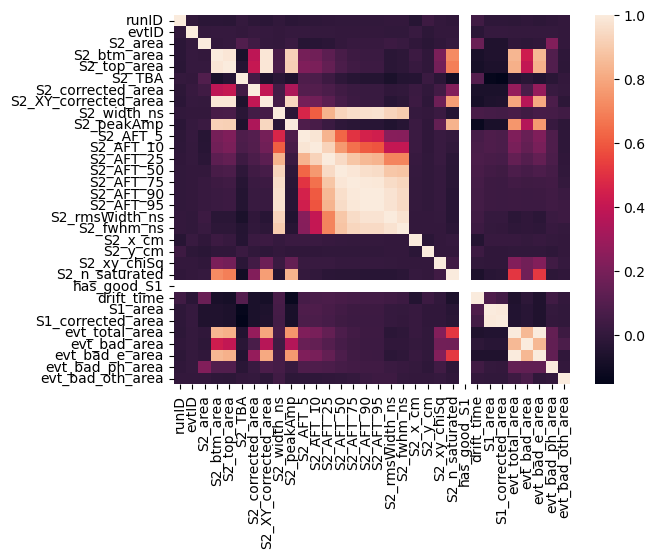

In [4]:
#plot everything against everything - corner plots n that 
corr_df = arr.corr()

corr_df.dropna()

sns.heatmap(corr_df,
           xticklabels = corr_df.columns,
           yticklabels=corr_df.columns,
           )



In [9]:
corr_df_cut=corr_df
for idx1 in corr_df.index:
    for idx2 in corr_df.index:
        if corr_df[idx1][idx2]>0.005:
            a=False
        else:
            a=True
        
    if a: 
        corr_df_cut=corr_df_cut.drop(index=idx1)
        corr_df_cut=corr_df_cut.drop(columns=idx1)
        

,S2_width_ns,S2_AFT_90,S2_AFT_95,S2_rmsWidth_ns,S2_xy_chiSq,evt_total_area,evt_bad_area,evt_bad_oth_area
S2_width_ns,1.000000,0.967155,0.970395,0.931546,0.020572,0.062179,0.036393,0.039130
S2_AFT_90,0.967155,1.000000,0.998960,0.973053,0.007703,0.032483,0.027719,0.021808
S2_AFT_95,0.970395,0.998960,1.000000,0.975486,0.007883,0.030502,0.026391,0.032388
S2_rmsWidth_ns,0.931546,0.973053,0.975486,1.000000,0.002993,-0.021128,-0.009236,0.029630
S2_xy_chiSq,0.020572,0.007703,0.007883,0.002993,1.000000,0.224914,0.182577,0.007854
evt_total_area,0.062179,0.032483,0.030502,-0.021128,0.224914,1.000000,0.848253,0.033413
evt_bad_area,0.036393,0.027719,0.026391,-0.009236,0.182577,0.848253,1.000000,0.072615
evt_bad_oth_area,0.039130,0.021808,0.032388,0.029630,0.007854,0.033413,0.072615,1.000000


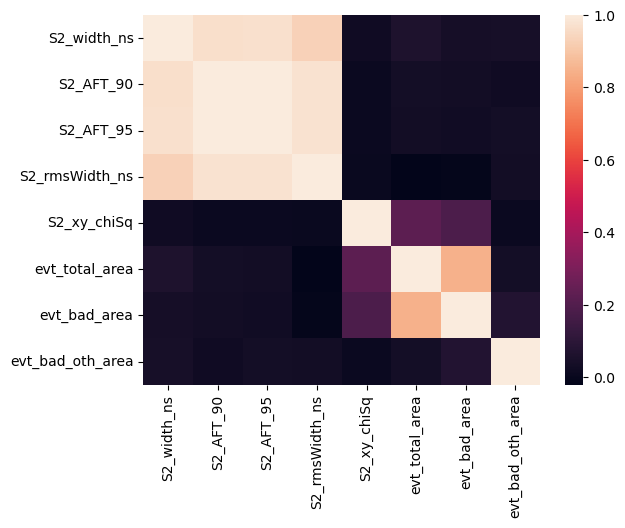

In [10]:
sns.heatmap(corr_df_cut,
           xticklabels = corr_df_cut.columns,
           yticklabels=corr_df_cut.columns,
           )
corr_df_cut

Text(0.5, 1.0, 'Plot of S1 and S2')

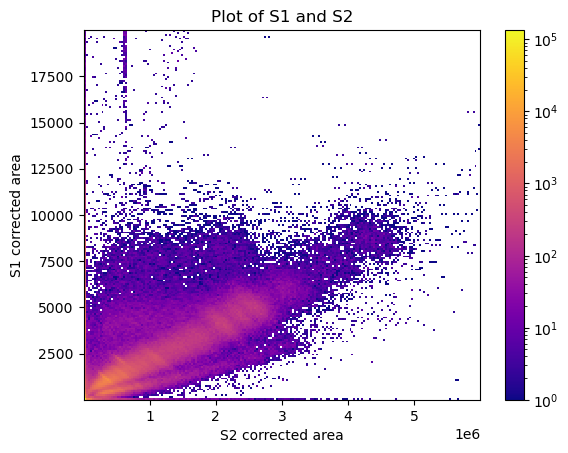

In [35]:
fig, ax = plt.subplots()
conditions=(arr['S2_corrected_area']<0.6e7) & (arr['S1_corrected_area']<20000)
h = ax.hist2d(arr['S2_corrected_area'].to_numpy()[conditions], 
              arr['S1_corrected_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 corrected area')
plt.ylabel('S1 corrected area')
plt.title('Plot of S1 and S2')

Text(0.5, 1.0, 'Plot of bad area and S2')

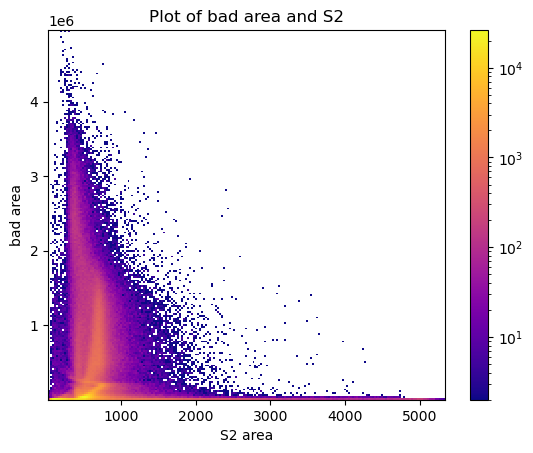

In [43]:
#plot for bad area 
fig, ax = plt.subplots()
conditions=(arr['S2_area']>0) & (arr['evt_bad_area']<0.5e7)
h = ax.hist2d(arr['S2_area'].to_numpy()[conditions], 
              arr['evt_bad_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 area')
plt.ylabel('bad area')
plt.title('Plot of bad area and S2')

Text(0.5, 1.0, 'Plot of bad electron area and S2')

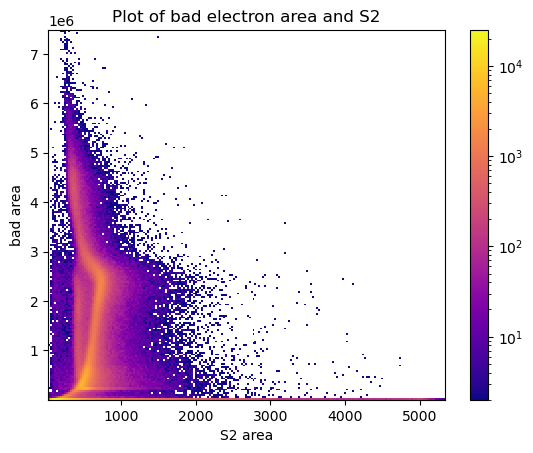

In [48]:
#plot for bad electron area 
fig, ax = plt.subplots()
conditions=(arr['S2_area']>0) & (arr['evt_bad_e_area']<0.75e7)
h = ax.hist2d(arr['S2_area'].to_numpy()[conditions], 
              arr['evt_bad_e_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 area')
plt.ylabel('bad electron area')
plt.title('Plot of bad electron area and S2')

Text(0.5, 1.0, 'Plot of bad photon area and S2')

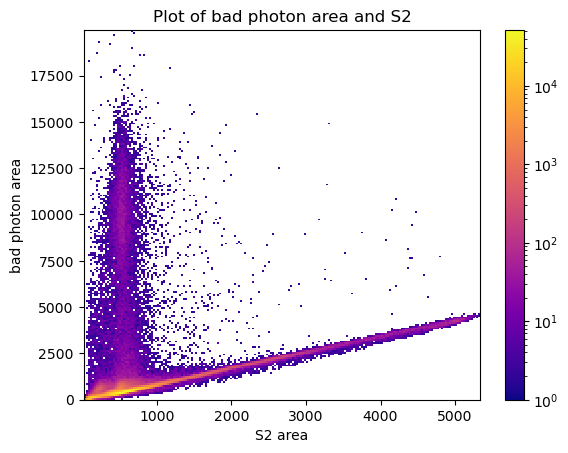

In [51]:
#plot for bad photon area 
fig, ax = plt.subplots()
conditions=(arr['S2_area']>0) & (arr['evt_bad_ph_area']<0.2e5)
h = ax.hist2d(arr['S2_area'].to_numpy()[conditions], 
              arr['evt_bad_ph_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 area')
plt.ylabel('bad photon area')
plt.title('Plot of bad photon area and S2')

Text(0.5, 1.0, 'Plot of other electron area and S2')

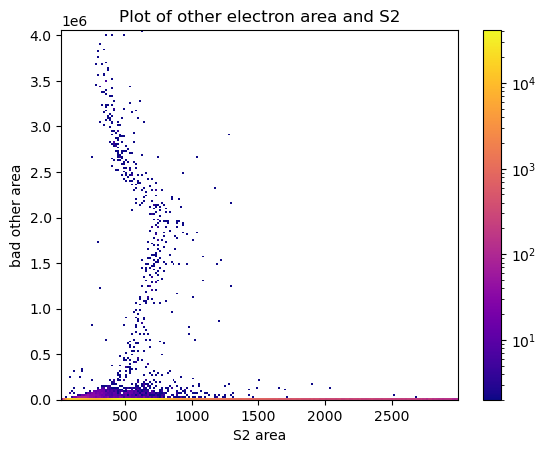

In [55]:
#plot for bad other area 
fig, ax = plt.subplots()
conditions=(arr['S2_area']<3000) & (arr['evt_bad_oth_area']<0.75e8)
h = ax.hist2d(arr['S2_area'].to_numpy()[conditions], 
              arr['evt_bad_oth_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 area')
plt.ylabel('bad other area')
plt.title('Plot of other electron area and S2')

Text(0.5, 1.0, 'Plot of electrons vs detected electrons')

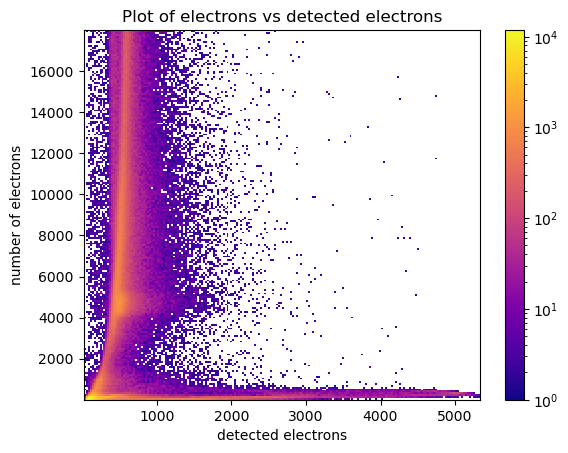

In [67]:
#Detected electrons (S2 area/ no of photons) vs Events/electrons 

#I don't know how to find these values...
#Beta spectrum – cutoff = 18 keV , Single electron = 58.5 phd
#E = W(s1/g1 + S2/g2)
#g1: 0.1136 phd/photon
#g2: 47.07 phd/electron --> maybe input into equation if we can find W

x = arr['S2_area']
y = arr['evt_total_area']/ 58.5

fig, ax = plt.subplots()
conditions=(x>0) & (y<18e3)
h = ax.hist2d(x[conditions], 
              y[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('detected electrons')
plt.ylabel('number of electrons')
plt.title('Plot of electrons vs detected electrons')

Text(0.5, 1.0, 'Plot of X vs Y area for S2')

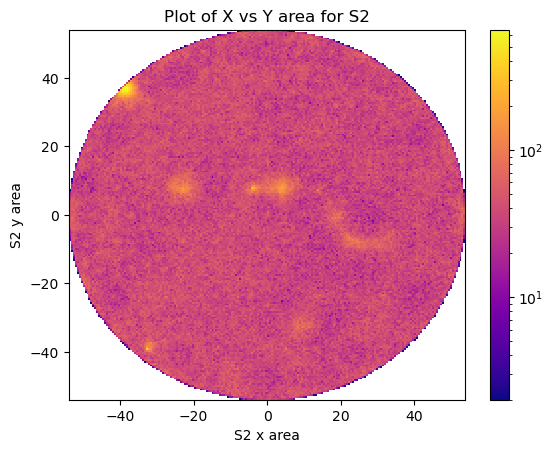

In [71]:
#plot x vs y with a cut select S2s between the threshold that you select and 50 detected electrons
#What we want to see is a very even distribution of tritium events in x vs y

x = arr['S2_x_cm']
y = arr['S2_y_cm']

fig, ax = plt.subplots()
h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 x area')
plt.ylabel('S2 y area')
plt.title('Plot of X vs Y area for S2')